### Call Marketplace Data Analysis
#### Anvesha Dutta

In [314]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

**Planning:**
Main points about the data:
- timeline: Oct 23-Mar 24 (5 months)
- conversion data from only buyer ID: 63253 available; all other rows NA
- call duration feature not used by buyers to use in bidding calc as data not available until after the call is over


**TASK**:
1.	Estimate the likelihood of conversion for every call in the dataset. 
2.	Use the estimate from 1 to explain which types of calls are more likely to convert.

**Roadmap:** 
- merge the 3 datasets 
- do data cleaning + feature engineering 
- random forest/other tree algos and look at feature imp 
- an ML problem; fit a model and use buyer ID 63253's conversion data as test data or ground truth to test the model's goodness of fit
- Question 1: append a likelihood col for submitting the final csv's 
- Question 2: "which types of calls..." - explain the most imp features based on algo+intuition 
- NOTE: exclude call duration feature in training

**Models to Try**:
1. Logistic Regression 
2. Tree based: Random forest and XGBoost
3. KNN
4. Naive Bayes?

### Exploratory Data Analysis and Data Preprocessing

#### Calls Datasets

In [315]:
#download the data
calls_2023 = pd.read_csv('health_calls_2023.csv')
calls_2024 = pd.read_csv('health_calls_2024.csv')
source = pd.read_csv('source.csv')
user_data = pd.read_csv('user_provided_data.csv')


/var/folders/yw/42xscsr10q573yfmjt23989r0000gn/T/ipykernel_81129/4278442944.py:5: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  user_data = pd.read_csv('user_provided_data.csv')


In [316]:
print(calls_2023.columns)
print(calls_2024.columns)
calls_2023.head()

Index(['call_id', 'phone_num_hash', 'buyer_id', 'source_id', 'time',
       'call_duration', 'conversion'],
      dtype='object')
Index(['call_id', 'phone_num_hash', 'buyer_id', 'source_id', 'time',
       'call_duration', 'conversion'],
      dtype='object')


,call_id,phone_num_hash,buyer_id,source_id,time,call_duration,conversion
0,CA25123ac8ae1550d20702684e9b383a9d,1E203B4634DCA46E4D4045C9CCAB0C14177B510A19AB14...,34844.0,3330,2023-10-01 00:18:54,145,NaN
1,CA12decc9f39cc43142ceef361dffed9cd,5A3B2644861B73B6D6E96FDDE9AA30A2D7E9E6CB3DB969...,66836.0,2932,2023-10-01 10:27:52,4,NaN
2,CA794a97d6b9dd98ddd4c205c809d96647,0120BC3605C132B962218270D4D64A5D025A81B225060C...,65405.0,8556,2023-10-01 11:05:25,375,NaN
3,CAf21c387e2a26acac8663704d4f36afc0,11CE200E32613B62B53E67A49C33B5E2C1BC03B3D0F2B0...,66836.0,5597,2023-10-01 11:19:19,1195,NaN
4,CAd88ef2c4ad0302a068ccb2658329b4b2,364534E0D49B18A923AB79BB2F4FF96216E4DAF0E0F005...,66836.0,3329,2023-10-01 11:59:11,92,NaN


In [317]:
calls_2024.head()

,call_id,phone_num_hash,buyer_id,source_id,time,call_duration,conversion
0,CA4106c8d504b4cc941ae615d8548a25b5,9A75F41BB88D7EC1ECF18B4081CB03EFDBF45A77DAFFD5...,66836.0,5597,2024-01-01 08:26:32,14,NaN
1,CA9a66a9b31f2a8a47cc147ede1d916a48,78FF9AE72F890318CF4DA2FE69C06F41EFDDB1BB57CCE6...,66836.0,2932,2024-01-01 08:39:15,4338,NaN
2,CA7fd06d01c5ffd463e479d1e1941b6727,91E93D1CC5D34C551BFF6745A0C3BEBBF8499FC6A58E61...,66836.0,3329,2024-01-01 09:02:14,1524,NaN
3,CAd38cfb3fbe7046ab7399349974cabb74,322571718D8FDA205F5F1D9EE697E0F815686DE715843B...,2282.0,2932,2024-01-01 09:08:46,1939,NaN
4,CA3e816dafd08e6280bd865829aaf78435,CB327F84B801CA164BC6103C5852FFB578CFAF41ECF6C1...,2282.0,2932,2024-01-01 09:10:58,2346,NaN


In [318]:
print(calls_2023.info(), '\n\n')
print(calls_2024.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46162 entries, 0 to 46161
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   call_id         46162 non-null  object 
 1   phone_num_hash  46162 non-null  object 
 2   buyer_id        46162 non-null  float64
 3   source_id       46162 non-null  int64  
 4   time            46162 non-null  object 
 5   call_duration   46162 non-null  int64  
 6   conversion      6985 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 2.5+ MB
None 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53384 entries, 0 to 53383
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   call_id         53384 non-null  object 
 1   phone_num_hash  53384 non-null  object 
 2   buyer_id        53384 non-null  float64
 3   source_id       53384 non-null  int64  
 4   time            53384 non-null  ob

In [319]:
# descriptive statistics
print(calls_2023.describe(), '\n\n')
print(calls_2024.describe())

            buyer_id     source_id  call_duration   conversion
count   46162.000000  4.616200e+04   46162.000000  6985.000000
mean    40048.277891  2.065555e+05     768.183918     0.172369
std     32985.600419  5.698061e+05     937.125296     0.377728
min       171.000000  2.830000e+02       0.000000     0.000000
25%      2350.000000  3.329000e+03     101.000000     0.000000
50%     40602.000000  3.330000e+03     403.500000     0.000000
75%     63253.000000  5.531000e+03    1111.000000     0.000000
max    106603.000000  2.007621e+06   10666.000000     1.000000 


            buyer_id     source_id  call_duration   conversion
count   53384.000000  5.338400e+04   53384.000000  6634.000000
mean    37253.367563  2.443177e+05     602.114847     0.137474
std     35718.405313  6.047137e+05     801.436168     0.344373
min       171.000000  2.830000e+02       0.000000     0.000000
25%      2282.000000  3.329000e+03      61.000000     0.000000
50%     34844.000000  3.330000e+03     271.000000   

In [320]:
#Checking the perqentage of missing values in the dataset
print(calls_2023.isnull().sum()/calls_2023.shape[0]*100, '\n\n')
print(calls_2024.isnull().sum()/calls_2024.shape[0]*100)

call_id            0.000000
phone_num_hash     0.000000
buyer_id           0.000000
source_id          0.000000
time               0.000000
call_duration      0.000000
conversion        84.868507
dtype: float64 


call_id            0.000000
phone_num_hash     0.000000
buyer_id           0.000000
source_id          0.000000
time               0.000000
call_duration      0.000000
conversion        87.573056
dtype: float64


In [321]:
#Concatenating the two call datasets
all_calls = pd.concat([calls_2023, calls_2024], axis=0)
print(all_calls.shape, '\n')
print(all_calls.shape[0] == calls_2023.shape[0] + calls_2024.shape[0], '\n')
print(all_calls.info())
all_calls.head()

(99546, 7) 

True 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99546 entries, 0 to 53383
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   call_id         99546 non-null  object 
 1   phone_num_hash  99546 non-null  object 
 2   buyer_id        99546 non-null  float64
 3   source_id       99546 non-null  int64  
 4   time            99546 non-null  object 
 5   call_duration   99546 non-null  int64  
 6   conversion      13619 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 6.1+ MB
None


,call_id,phone_num_hash,buyer_id,source_id,time,call_duration,conversion
0,CA25123ac8ae1550d20702684e9b383a9d,1E203B4634DCA46E4D4045C9CCAB0C14177B510A19AB14...,34844.0,3330,2023-10-01 00:18:54,145,NaN
1,CA12decc9f39cc43142ceef361dffed9cd,5A3B2644861B73B6D6E96FDDE9AA30A2D7E9E6CB3DB969...,66836.0,2932,2023-10-01 10:27:52,4,NaN
2,CA794a97d6b9dd98ddd4c205c809d96647,0120BC3605C132B962218270D4D64A5D025A81B225060C...,65405.0,8556,2023-10-01 11:05:25,375,NaN
3,CAf21c387e2a26acac8663704d4f36afc0,11CE200E32613B62B53E67A49C33B5E2C1BC03B3D0F2B0...,66836.0,5597,2023-10-01 11:19:19,1195,NaN
4,CAd88ef2c4ad0302a068ccb2658329b4b2,364534E0D49B18A923AB79BB2F4FF96216E4DAF0E0F005...,66836.0,3329,2023-10-01 11:59:11,92,NaN


In [322]:
#converting the date columns from object type to datetime
all_calls['time'] = pd.to_datetime(all_calls['time'])

#adding new colums for day of week and hour of day
all_calls['day_of_week'] = all_calls['time'].dt.day_of_week
all_calls['hour_of_day'] = all_calls['time'].dt.hour

#converting all NaN values in the 'conversion' column to -1
all_calls['conversion'] = all_calls['conversion'].fillna(-1)

print(all_calls.info())
all_calls.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99546 entries, 0 to 53383
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   call_id         99546 non-null  object        
 1   phone_num_hash  99546 non-null  object        
 2   buyer_id        99546 non-null  float64       
 3   source_id       99546 non-null  int64         
 4   time            99546 non-null  datetime64[ns]
 5   call_duration   99546 non-null  int64         
 6   conversion      99546 non-null  float64       
 7   day_of_week     99546 non-null  int64         
 8   hour_of_day     99546 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 7.6+ MB
None


,call_id,phone_num_hash,buyer_id,source_id,time,call_duration,conversion,day_of_week,hour_of_day
0,CA25123ac8ae1550d20702684e9b383a9d,1E203B4634DCA46E4D4045C9CCAB0C14177B510A19AB14...,34844.0,3330,2023-10-01 00:18:54,145,-1.0,6,0
1,CA12decc9f39cc43142ceef361dffed9cd,5A3B2644861B73B6D6E96FDDE9AA30A2D7E9E6CB3DB969...,66836.0,2932,2023-10-01 10:27:52,4,-1.0,6,10
2,CA794a97d6b9dd98ddd4c205c809d96647,0120BC3605C132B962218270D4D64A5D025A81B225060C...,65405.0,8556,2023-10-01 11:05:25,375,-1.0,6,11
3,CAf21c387e2a26acac8663704d4f36afc0,11CE200E32613B62B53E67A49C33B5E2C1BC03B3D0F2B0...,66836.0,5597,2023-10-01 11:19:19,1195,-1.0,6,11
4,CAd88ef2c4ad0302a068ccb2658329b4b2,364534E0D49B18A923AB79BB2F4FF96216E4DAF0E0F005...,66836.0,3329,2023-10-01 11:59:11,92,-1.0,6,11


In [323]:
all_calls.conversion.value_counts(normalize=True)*100

-1.0    86.318888
 0.0    11.555462
 1.0     2.125650
Name: conversion, dtype: float64

In [324]:
all_calls.isnull().sum()

call_id           0
phone_num_hash    0
buyer_id          0
source_id         0
time              0
call_duration     0
conversion        0
day_of_week       0
hour_of_day       0
dtype: int64

#### User Data and Source Data

In [325]:
#checking the source dataset for any missing values 
print(source.info(), '\n')
print(source.isnull().sum()/source.shape[0]*100)
source.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source_id    74 non-null     int64 
 1   seller_id    74 non-null     int64 
 2   seller_type  74 non-null     object
dtypes: int64(2), object(1)
memory usage: 1.9+ KB
None 

source_id      0.0
seller_id      0.0
seller_type    0.0
dtype: float64


,source_id,seller_id,seller_type
0,283,1,owned_and_operated
1,2466,387,owned_and_operated
2,2932,325,owned_and_operated
3,3329,506,owned_and_operated
4,3330,507,owned_and_operated


No missing values in the source dataset

In [326]:
#checking the user dataset for any missing values and descriptive statistics
print(user_data.info(), '\n')
print(user_data.isnull().sum()/user_data.shape[0]*100, '\n')
print(user_data.describe(), '\n')
user_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99546 entries, 0 to 99545
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   call_id            99546 non-null  object 
 1   state              99546 non-null  object 
 2   currently_insured  816 non-null    float64
 3   connection_type    99546 non-null  object 
 4   browser            99515 non-null  object 
 5   browser_platform   99208 non-null  object 
 6   device             99546 non-null  object 
 7   age                98733 non-null  float64
 8   bmi                314 non-null    float64
 9   coverage_type      7 non-null      object 
 10  credit_rating      0 non-null      float64
 11  current_company    785 non-null    object 
 12  gender             98720 non-null  object 
 13  height             314 non-null    float64
 14  household_income   98969 non-null  float64
 15  married            0 non-null      float64
 16  household_size     995

,call_id,state,currently_insured,connection_type,browser,browser_platform,device,age,bmi,coverage_type,credit_rating,current_company,gender,height,household_income,married,household_size,subsidy,weight
0,CA0000c26f73aff039654de6735e9df84b,NM,NaN,broadband,chrome,chrome,computer,59.3,NaN,NaN,NaN,NaN,male,NaN,16000.0,NaN,1,medicaid,NaN
1,CA0001d88a5aca21d1495657d54c6cfc65,PA,NaN,broadband,chrome,android,mobile,54.8,NaN,NaN,NaN,NaN,female,NaN,23500.0,NaN,1,yes,NaN
2,CA0004cc3434144475291e519fb581f07c,IN,NaN,broadband,edge,windows,computer,36.1,NaN,NaN,NaN,NaN,male,NaN,16000.0,NaN,2,medicaid,NaN
3,CA0004dcd8904702ded81e01dc0a747ad2,PA,NaN,broadband,safari,ios,mobile,28.0,NaN,NaN,NaN,NaN,male,NaN,23500.0,NaN,1,yes,NaN
4,CA0006326031271ee0c0e08ba3e09bdfab,TX,NaN,broadband,chrome,android,mobile,44.3,NaN,NaN,NaN,NaN,female,NaN,16000.0,NaN,1,medicaid,NaN


In [327]:
#checking the number of unique values of the categorical variables in the dataset
print(user_data.select_dtypes(include=['object']).nunique(), '\n')
cat_vars = ['connection_type', 'browser', 'browser_platform', 'device', 'coverage_type', 
            'current_company', 'gender', 'subsidy']
#checking the percentage of each category in some of the categorical variables
for col in cat_vars:
    print(user_data[col].value_counts(normalize=True)*100, '\n')



call_id             99546
state                  52
connection_type         4
browser                 8
browser_platform        7
device                  4
coverage_type           1
current_company         2
gender                  3
subsidy                 3
dtype: int64 

broadband    64.248689
cellular     27.562132
corporate     7.496032
unknown       0.693147
Name: connection_type, dtype: float64 

chrome            44.852535
safari            33.036226
edge               9.803547
facebook           6.611064
instagram          3.347234
samsungbrowser     1.264131
firefox            0.985781
other              0.099482
Name: browser, dtype: float64 

ios        37.336707
android    28.147932
windows    25.004032
mac         7.365333
chrome      1.889969
linux       0.224780
other       0.031247
Name: browser_platform, dtype: float64 

mobile      63.839833
computer    34.331867
tablet       1.797159
other        0.031141
Name: device, dtype: float64 

cobra    100.0
Name: coverage_

In [328]:
# removing the columns from the user_data dataset that have 90%+ missing values for more robust results
# the user dataset has the same number of rows as the concatenated calls dataset so each row must be a unique call in each
cols_remove = ['currently_insured', 'bmi', 'coverage_type', 'credit_rating',
               'current_company', 'height', 'married', 'weight']
user_data.drop(columns=cols_remove, axis=1, inplace=True)

#check for remaining missing values
print(user_data.isnull().sum().sort_values(ascending=False)/user_data.shape[0]*100, '\n')
user_data.head()

gender              0.829767
age                 0.816708
subsidy             0.784562
household_income    0.579632
browser_platform    0.339542
browser             0.031141
call_id             0.000000
state               0.000000
connection_type     0.000000
device              0.000000
household_size      0.000000
dtype: float64 



,call_id,state,connection_type,browser,browser_platform,device,age,gender,household_income,household_size,subsidy
0,CA0000c26f73aff039654de6735e9df84b,NM,broadband,chrome,chrome,computer,59.3,male,16000.0,1,medicaid
1,CA0001d88a5aca21d1495657d54c6cfc65,PA,broadband,chrome,android,mobile,54.8,female,23500.0,1,yes
2,CA0004cc3434144475291e519fb581f07c,IN,broadband,edge,windows,computer,36.1,male,16000.0,2,medicaid
3,CA0004dcd8904702ded81e01dc0a747ad2,PA,broadband,safari,ios,mobile,28.0,male,23500.0,1,yes
4,CA0006326031271ee0c0e08ba3e09bdfab,TX,broadband,chrome,android,mobile,44.3,female,16000.0,1,medicaid


Missing Data Imputation can be done after merging the datasets.

### Merging the Datasets

In [329]:
merged_1 = pd.merge(all_calls, user_data, on='call_id', how='inner')
print(merged_1.shape, '\n')

merged = pd.merge(merged_1, source, on='source_id', how='inner')
print(merged.shape, '\n')
print(merged.isnull().sum().sort_values(ascending=False)/merged.shape[0]*100, '\n')
merged.head()

(99546, 19) 

(99546, 21) 

gender              0.829767
age                 0.816708
subsidy             0.784562
household_income    0.579632
browser_platform    0.339542
browser             0.031141
call_id             0.000000
seller_id           0.000000
household_size      0.000000
device              0.000000
connection_type     0.000000
phone_num_hash      0.000000
state               0.000000
hour_of_day         0.000000
day_of_week         0.000000
conversion          0.000000
call_duration       0.000000
time                0.000000
source_id           0.000000
buyer_id            0.000000
seller_type         0.000000
dtype: float64 



,call_id,phone_num_hash,buyer_id,source_id,time,call_duration,conversion,day_of_week,hour_of_day,state,...,browser,browser_platform,device,age,gender,household_income,household_size,subsidy,seller_id,seller_type
0,CA25123ac8ae1550d20702684e9b383a9d,1E203B4634DCA46E4D4045C9CCAB0C14177B510A19AB14...,34844.0,3330,2023-10-01 00:18:54,145,-1.0,6,0,PA,...,chrome,android,mobile,51.3,male,23500.0,1,yes,507,owned_and_operated
1,CA0bf360c2e450496ab7f9827ca53c2782,C0A651D4E963BF925E4B641C456C219944346F7D0C2C1B...,66836.0,3330,2023-10-01 12:19:35,1705,-1.0,6,12,KY,...,chrome,android,mobile,40.3,male,40000.0,1,yes,507,owned_and_operated
2,CA2c303f8186fcf2783398916949fbdfbc,6FF94E1E927AB3269BA8ACB0DC13FDB4CD5E5D6C26563C...,1987.0,3330,2023-10-01 18:41:09,1,-1.0,6,18,LA,...,chrome,android,mobile,56.8,male,40000.0,2,yes,507,owned_and_operated
3,CA694b6e2c7ed47d0ccb070e63339b3703,B3B0CE54CBB8C872CFEFF86EC3767A383200537A5C0094...,2486.0,3330,2023-10-01 22:34:43,156,-1.0,6,22,AZ,...,safari,ios,mobile,52.9,male,100000.0,4,yes,507,owned_and_operated
4,CAe560088516553c703a6e2426a3295994,EB098A09FA9EF17E3D34B97168EBF924BF253A81DD32A2...,1728.0,3330,2023-10-02 06:04:34,159,-1.0,0,6,GA,...,chrome,android,mobile,37.2,female,9500.0,1,medicaid,507,owned_and_operated


### Missing Values Handling/Imputation

Finding the proportion of total rows with missing values to decide method of missing values imputation/removal

In [330]:
# Count the number of rows with missing values across multiple columns
all_missing_rows = merged.isnull().any(axis=1).sum()

# Calculate the percentage of rows with missing values across multiple columns
percent_missing_mul_cols = all_missing_rows / len(merged) * 100

print(f"Number of rows with missing values across multiple columns: {all_missing_rows}")
print(f"Percentage of rows with missing values across multiple columns: {percent_missing_mul_cols:.2f}%")

Number of rows with missing values across multiple columns: 1380
Percentage of rows with missing values across multiple columns: 1.39%


Since, the percentage of missing values is about 1.4%, we can first investigate whether the values are missing at random, in which case, it would be okay to drop them. Otherwise, if statistical tests show significant results, then imputation would be more appropriate.

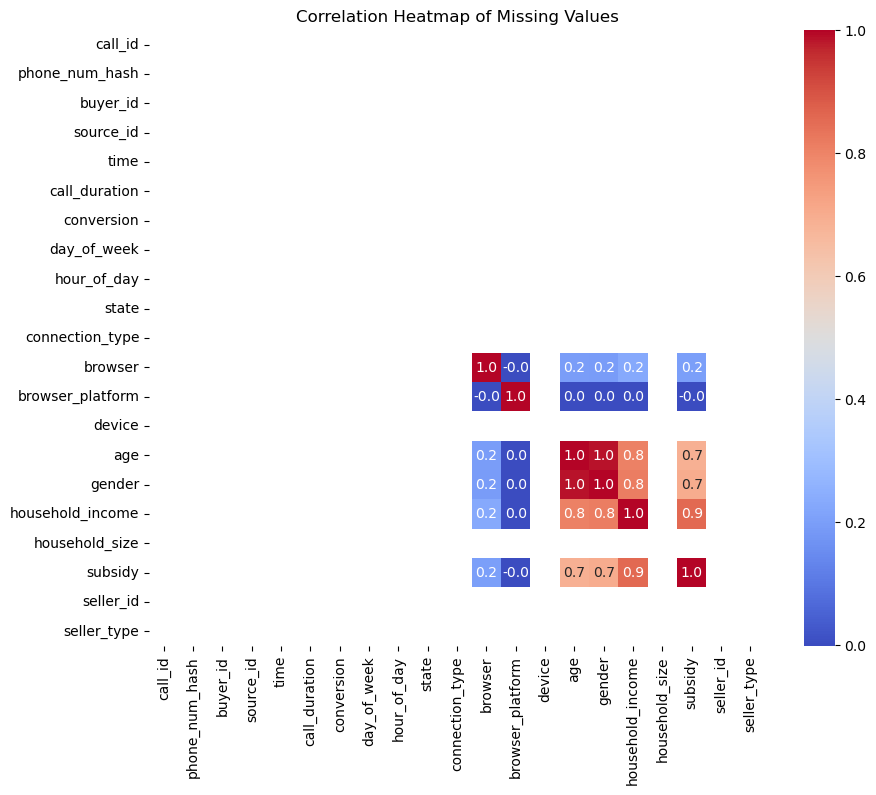

In [331]:
# checking for any correlation between the variables with missing values
missing_indicator = merged.isnull().astype(int)

# Compute the correlation matrix for the missing indicator
correlation_matrix = missing_indicator.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.1f')
plt.title('Correlation Heatmap of Missing Values')
plt.show()

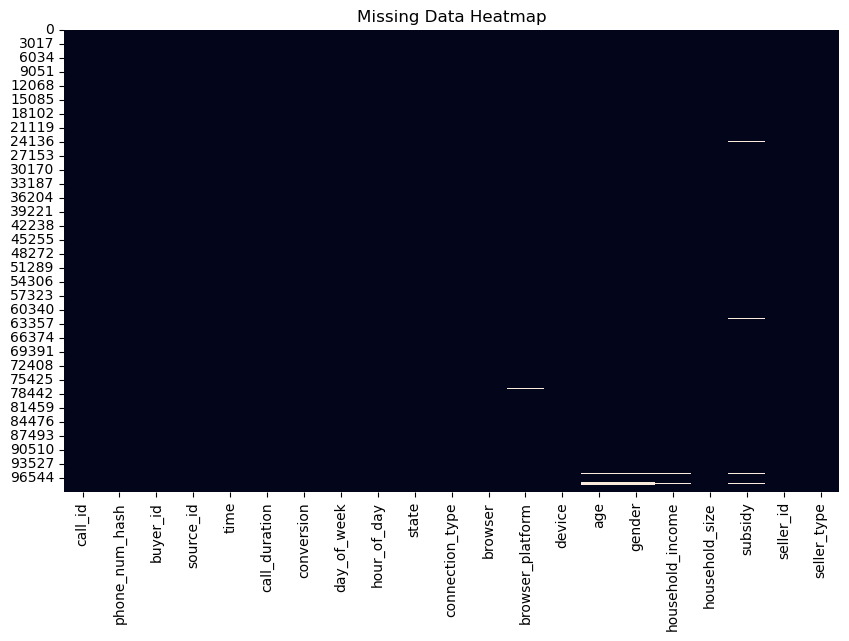

In [332]:
plt.figure(figsize=(10, 6))
sns.heatmap(merged.isnull(), cbar=False)
plt.title('Missing Data Heatmap')
plt.show()

The above correlation heatmap shows that age, gender, household income and subsidy are all strongly correlated columns. The missing data heatmap further confirms that the data points are Missing Not at Random (MNAR) for the features age, gender, household income and subsidy since they share the same missingness pattern. Thus, we employ impuration methods for these features and drop the rest.

In [333]:
#Drop NaN values for the columns: browser and browser_platform
merged.dropna(subset=['browser', 'browser_platform'], inplace=True)

count    98398.000000
mean        41.403779
std         13.865824
min         11.400000
25%         28.700000
50%         40.500000
75%         54.200000
max         89.500000
Name: age, dtype: float64


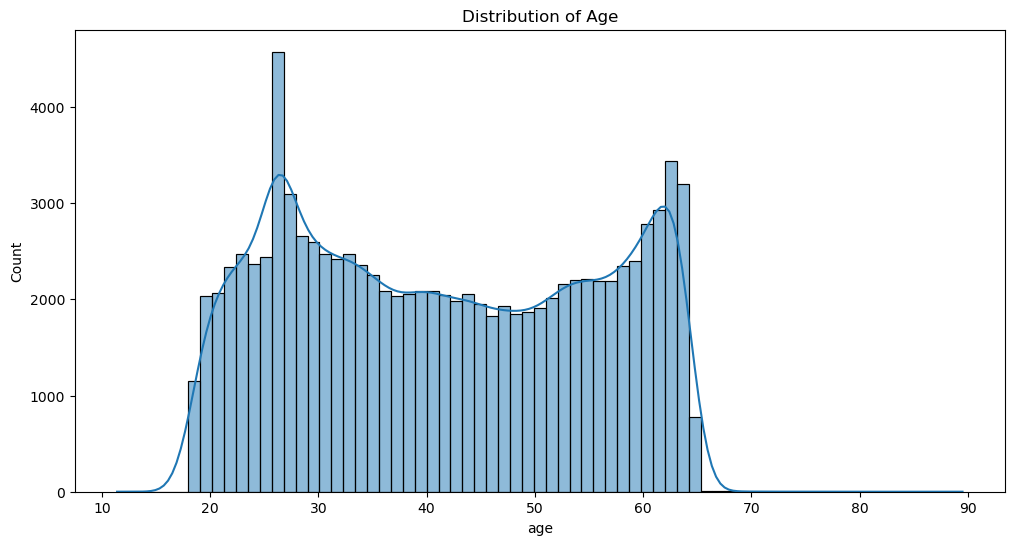

In [334]:
#plotting the distribution of the age and household income columns to determine the best method to fill the missing values
plt.figure(figsize=(12, 6))
sns.histplot(merged['age'], kde=True)
plt.title('Distribution of Age')
print(merged['age'].describe())

In [335]:
# see the distribution of the income column since due to its wide range, a visual is hard to generate
print(merged['household_income'].describe())

count    9.863300e+04
mean     8.324972e+04
std      1.367568e+07
min      0.000000e+00
25%      2.050000e+04
50%      3.700000e+04
75%      4.000000e+04
max      4.294967e+09
Name: household_income, dtype: float64


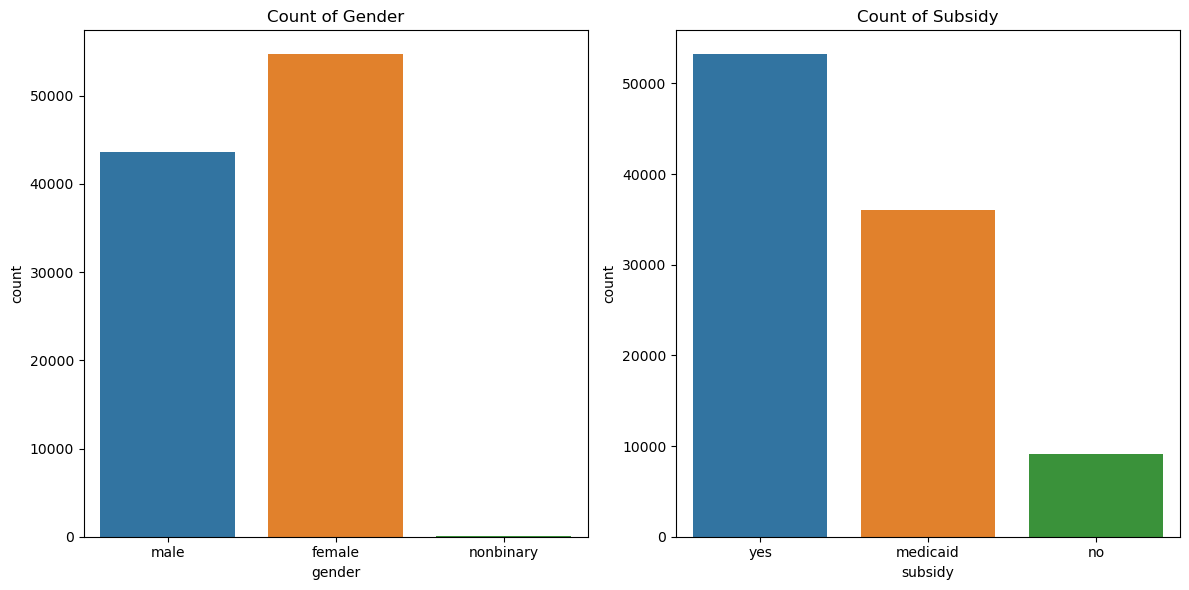

In [336]:
#see the distribution of the gender and subsidy columns
plt.figure(figsize=(12, 6))
# Count plot for gender
plt.subplot(1, 2, 1)
sns.countplot(data=merged, x='gender')
plt.title('Count of Gender')
# Count plot for subsidy
plt.subplot(1, 2, 2)
sns.countplot(data=merged, x='subsidy')
plt.title('Count of Subsidy')

plt.tight_layout()
plt.show()

In [337]:
# filling the missing values in the 'age' column with the mean (mean and median are almost equal)
# filling NaN values in the 'household_income' column with the median since it has extreme values affecting the mean
merged['age'] = merged['age'].fillna(merged['age'].mean())
merged['household_income'] = merged['household_income'].fillna(merged['household_income'].median())

# Forward fill missing values in 'gender' and 'subsidy' columns to keep the distribution of the data intact
merged['gender'].fillna(method='ffill', inplace=True)
merged['subsidy'].fillna(method='ffill', inplace=True)

#checking if there are any missing values left in the dataset
print(merged.isnull().any().sum())


0


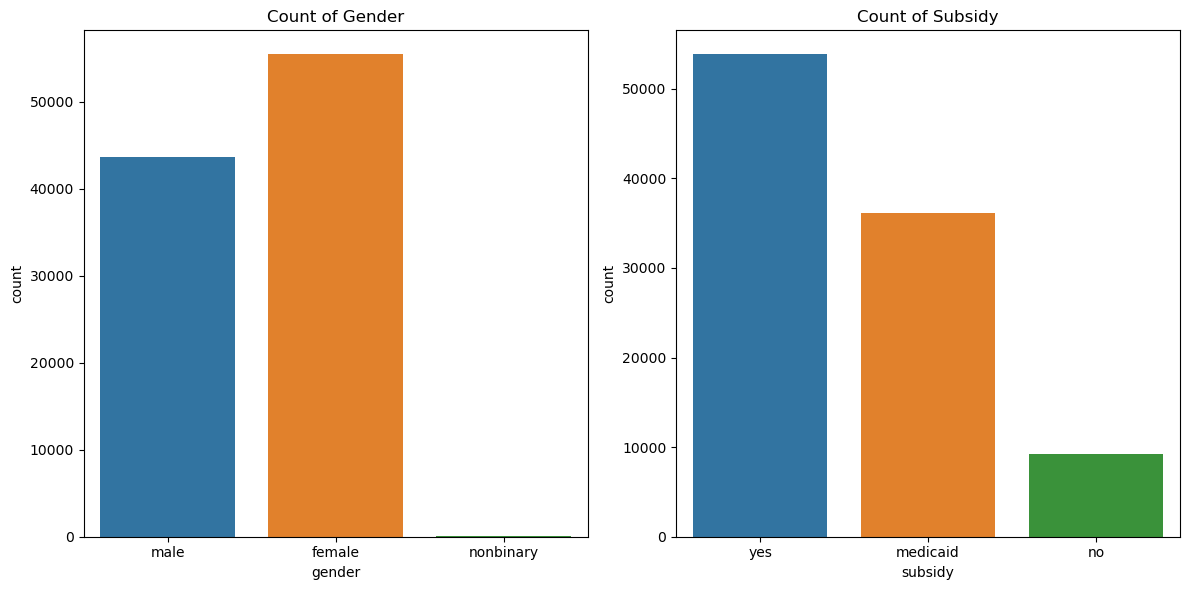

In [338]:
#see the distribution of the gender and subsidy columns post imputation
plt.figure(figsize=(12, 6))
# Count plot for gender
plt.subplot(1, 2, 1)
sns.countplot(data=merged, x='gender')
plt.title('Count of Gender')
# Count plot for subsidy
plt.subplot(1, 2, 2)
sns.countplot(data=merged, x='subsidy')
plt.title('Count of Subsidy')

plt.tight_layout()
plt.show()

In [339]:
merged.shape #about 369 rows dropped

(99177, 21)

Now that data cleaning is done, we can look at some visualizations to explore the data.

#### Some EDA Visualizations

<Axes: >

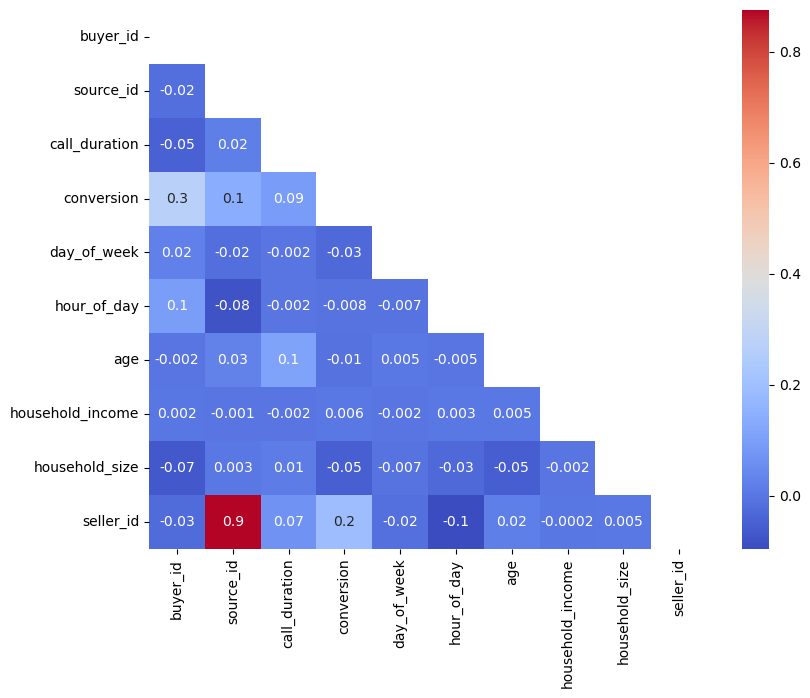

In [340]:
#checking any correlation between the columns
num_cols = merged.select_dtypes(include=['float64', 'int64'])
cat_cols = merged.select_dtypes(include=['object'])
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(num_cols.corr(), dtype=bool))
plt.figure(figsize=(9, 7))
sns.heatmap(num_cols.corr(), annot=True, mask=mask, cmap= 'coolwarm', fmt='.1g')

Only source_id and seller_id seem to have a very strong correlation, which is natural given their relationship of a page and a website.

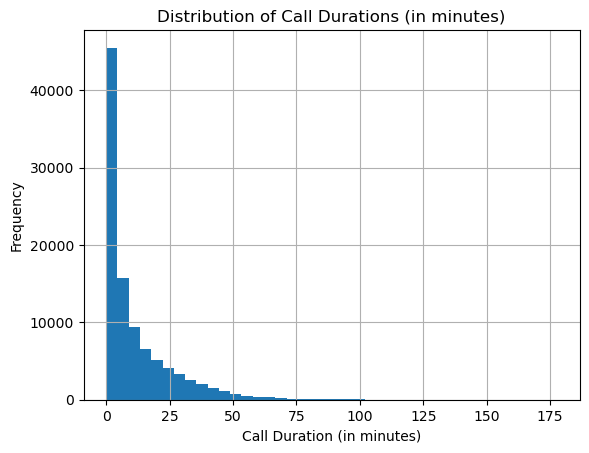

In [341]:
(all_calls['call_duration']/60).hist(bins=40)
plt.xlabel('Call Duration (in minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Call Durations (in minutes)')
plt.show()

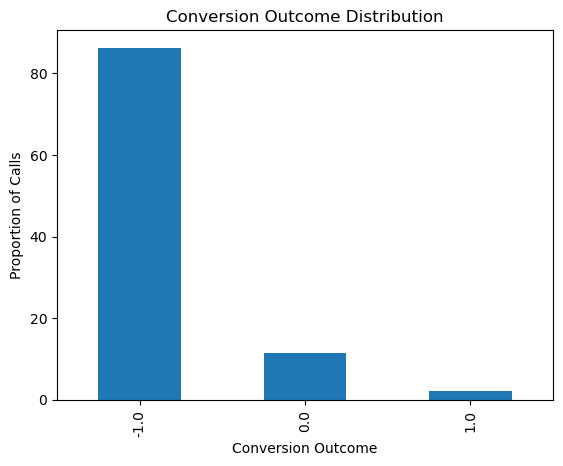

In [342]:
(all_calls['conversion'].value_counts(normalize=True)*100).plot(kind='bar')
plt.xlabel('Conversion Outcome')
plt.ylabel('Proportion of Calls')
plt.title('Conversion Outcome Distribution')
plt.show()

Most calls have no outcome recorded (~85%), about 10% have negative outcomes and around 2% of the calls have a positive conversion result.

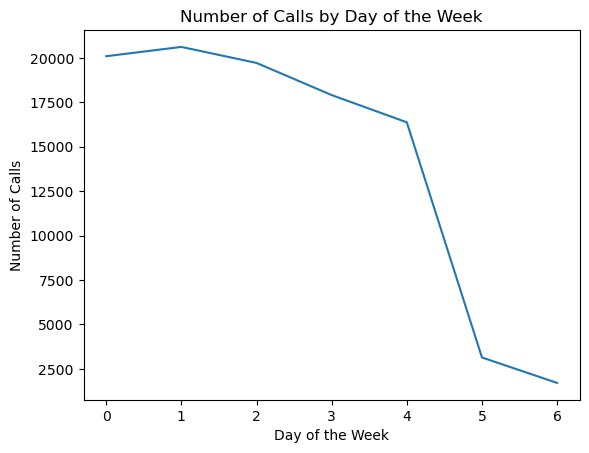

In [343]:
all_calls['day_of_week'].value_counts().sort_index().plot(kind='line')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Calls')
plt.title('Number of Calls by Day of the Week')
plt.show()

The most number of calls are natually made during the beginning of the week on Monday (0), Tuesday (1) and Wednesday (2) and the number of calls show a sharp decline post Friday (4).

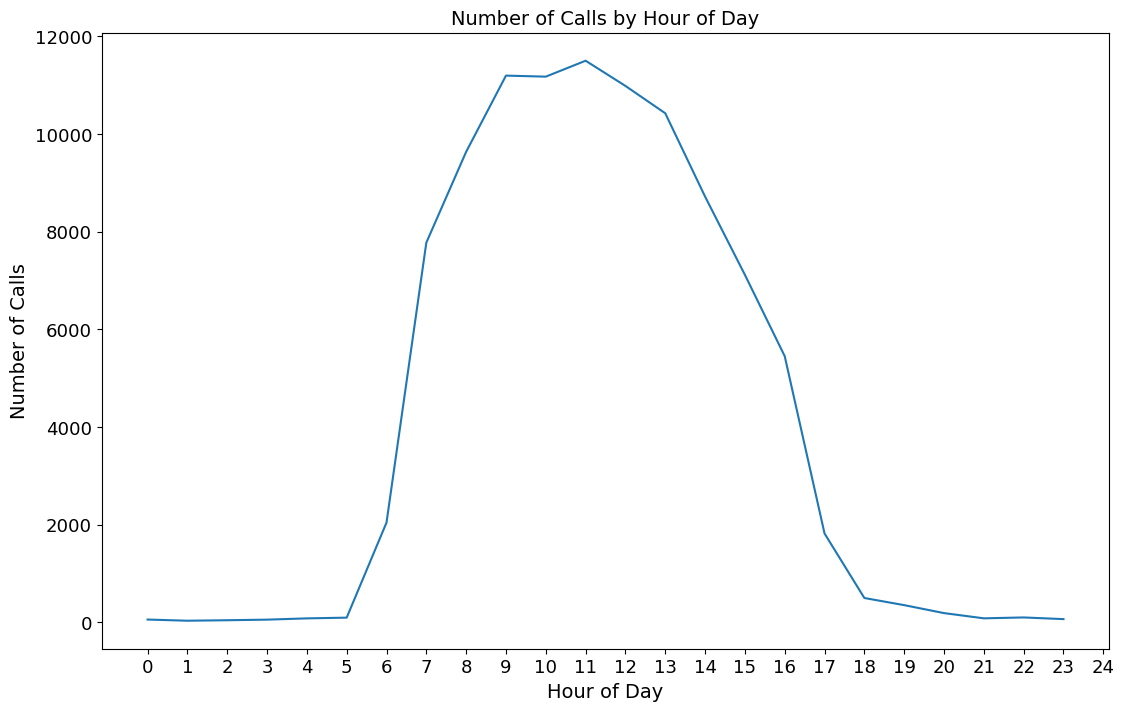

In [344]:
plt.figure(figsize=(13, 8))
all_calls['hour_of_day'].value_counts().sort_index().plot(kind='line')
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Number of Calls', fontsize=14)
plt.title('Number of Calls by Hour of Day', fontsize=14)
plt.xticks(range(25), fontsize=13)  # Increase x-ticks text size
plt.yticks(fontsize=13)  # Ensure all hours 0 through 24 are shown
plt.show()

Most calls are made starting 6am and ending at the usual business hours' end time, 5-6pm. The curve reaches its peak between 9am to 1pm.

Checking the conversion by few of the features to see any visible patterns.

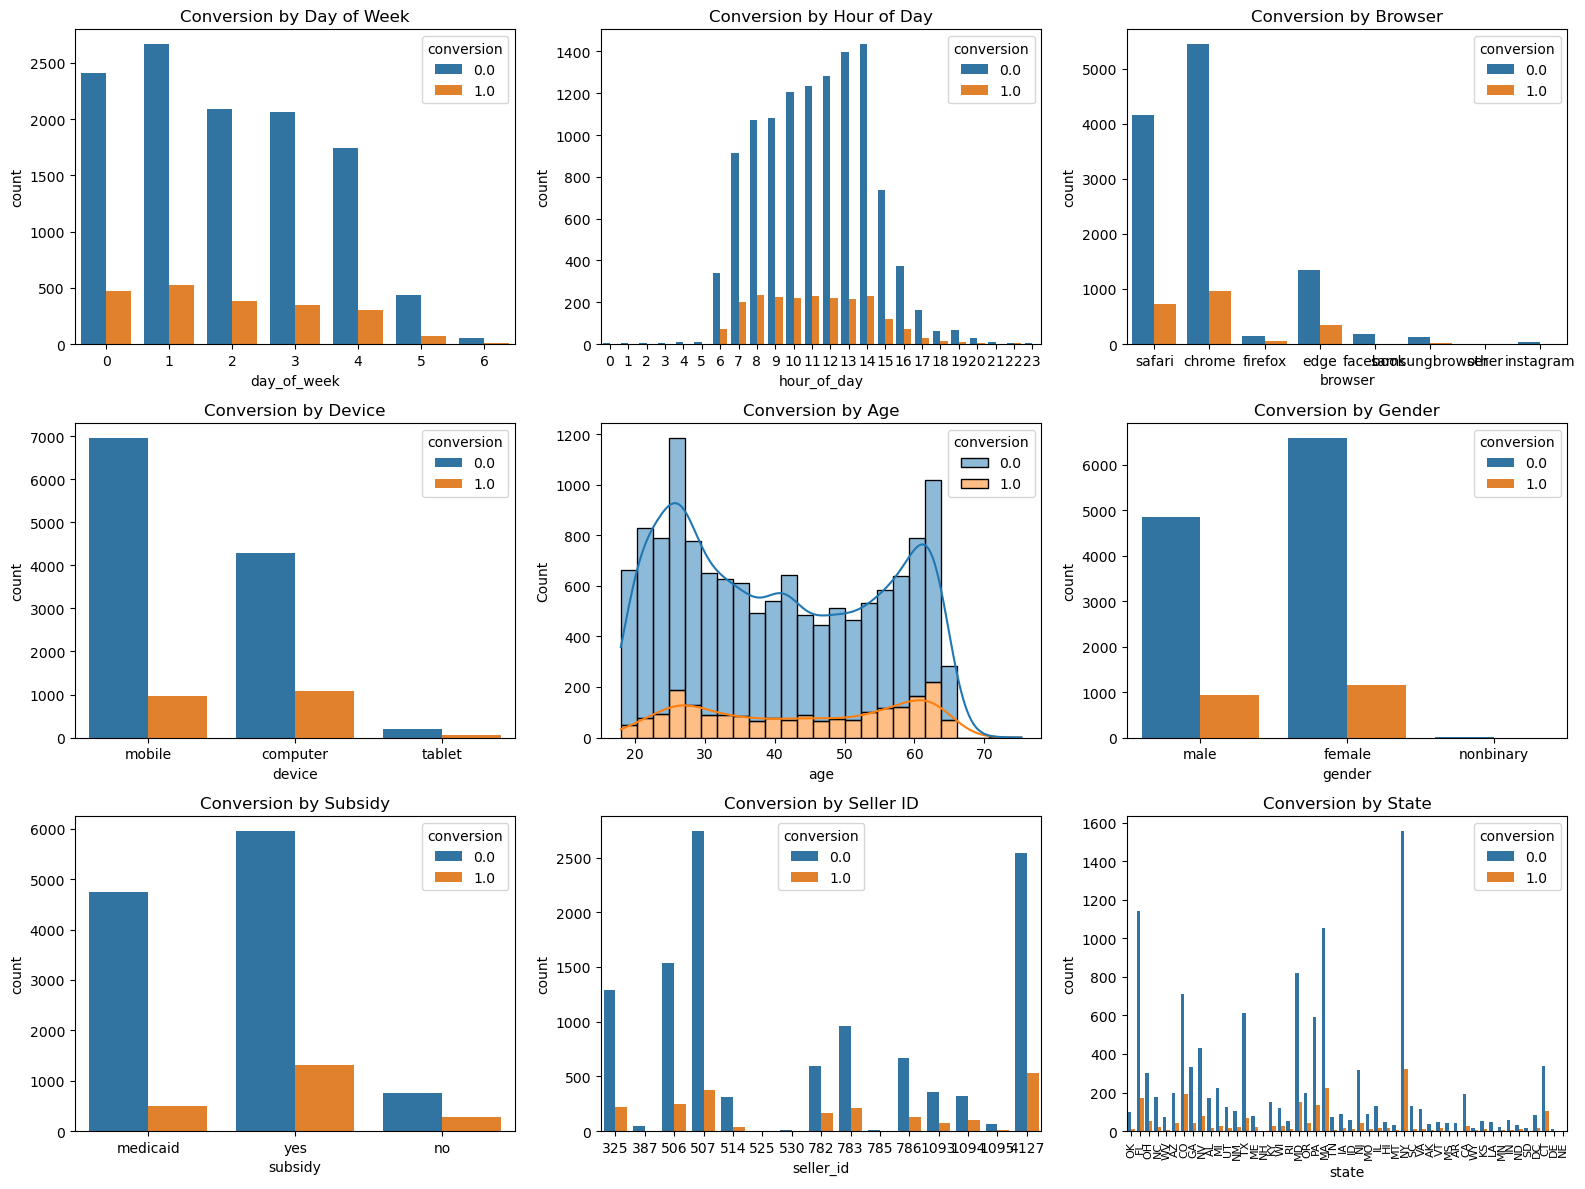

In [345]:
# Only consider the rows with ground truth values present for conversion 
ground_truth = merged[merged['conversion'] != -1]

# Conversion by day of the week
plt.figure(figsize=(16, 12))
plt.subplot(3, 3, 1)
sns.countplot(data=ground_truth, x=ground_truth['day_of_week'], hue='conversion')
plt.title('Conversion by Day of Week')

# Conversion by hour of day
plt.subplot(3, 3, 2)
sns.countplot(data=ground_truth, x=ground_truth['hour_of_day'], hue='conversion')
plt.title('Conversion by Hour of Day')

# Conversion by browser
plt.subplot(3, 3, 3)
sns.countplot(data=ground_truth, x=ground_truth['browser'], hue='conversion')
plt.title('Conversion by Browser')

# Conversion by device
plt.subplot(3, 3, 4)
sns.countplot(data=ground_truth, x=ground_truth['device'], hue='conversion')
plt.title('Conversion by Device')

# Conversion by age
plt.subplot(3, 3, 5)
sns.histplot(data=ground_truth, x=ground_truth['age'], hue='conversion', multiple='stack', kde=True)
plt.title('Conversion by Age')

# Conversion by gender
plt.subplot(3, 3, 6)
sns.countplot(data=ground_truth, x=ground_truth['gender'], hue='conversion')
plt.title('Conversion by Gender')

# Conversion by subsidy
plt.subplot(3, 3, 7)
sns.countplot(data=ground_truth, x=ground_truth['subsidy'], hue='conversion')
plt.title('Conversion by Subsidy')

# Conversion by seller_id
plt.subplot(3, 3, 8)
sns.countplot(data=ground_truth, x=ground_truth['seller_id'], hue='conversion')
plt.title('Conversion by Seller ID')

# Conversion by state
plt.subplot(3, 3, 9)
sns.countplot(data=ground_truth, x=ground_truth['state'], hue='conversion')
plt.title('Conversion by State')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

There are no patterns that stand out from the above diagrams.

The next step would be modeling.

### Feature Engineering and Model Fitting

I plan on trying out the following models to predict the likelihood of conversion for each call based on the given data: Logistic Regression and Random Forest.\
First, we'd have to split the data into test and train sets from all the rows that we know the ground truth of (buyer ID: 63253) and then use the model to predict the likelihoods of conversion for the remaining calls.

In [346]:
# splitting the data into 2 sets: known_outcomes which will be used to train and test the models and unknown_outcomes whose conversion outcomes are to be predicted
known_outcomes = ground_truth
known_outcomes.set_index('call_id', inplace=True)
unknown_outcomes = merged[merged['conversion'] == -1]

In [347]:
print(known_outcomes.nunique().sort_values(ascending=False), '\n')
print(known_outcomes.info())


phone_num_hash      13530
time                13481
call_duration        2788
age                   470
household_income      101
state                  50
hour_of_day            24
source_id              22
seller_id              15
browser                 8
day_of_week             7
household_size          7
browser_platform        6
connection_type         4
device                  3
gender                  3
subsidy                 3
conversion              2
buyer_id                1
seller_type             1
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
Index: 13558 entries, CA071976935937ae8ec8af13b58c43cd41 to CA0f2235e25f1c9278b16911b6aa3ac3dd
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   phone_num_hash    13558 non-null  object        
 1   buyer_id          13558 non-null  float64       
 2   source_id         13558 non-null  int64         
 3   time              13558 

Dropping the columns that won't be used in training the model: call_id is set as the index for unique identification, phone_num_hash has too many unique values to be encoded, buyer_id can't be trained on, time has already been broken down into 2 other features, source_id can be replaced by seller_id since it's a page within the website, call_duration can't be used as stated in the problem statement for bidding calculations, state has 50 categories which is too many to be encoded, seller_type is just one unique value and conversion is the target variable that we're trying to predict.

In [348]:
known_outcomes.drop(columns=['phone_num_hash', 'buyer_id', 'time', 'source_id',
                                 'time', 'call_duration', 'state', 
                                 'seller_type', 'seller_id'], inplace=True)
# splitting the data into the training features and target variable
X = known_outcomes.drop(columns='conversion')
y = known_outcomes['conversion']

/var/folders/yw/42xscsr10q573yfmjt23989r0000gn/T/ipykernel_81129/3875376204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known_outcomes.drop(columns=['phone_num_hash', 'buyer_id', 'time', 'source_id',


In [349]:
X.head()

,day_of_week,hour_of_day,connection_type,browser,browser_platform,device,age,gender,household_income,household_size,subsidy
call_id,,,,,,,,,,,
CA071976935937ae8ec8af13b58c43cd41,0,7,broadband,safari,ios,mobile,35.9,male,20000.0,1,medicaid
CAef4dd29b4f57fa15698f815afd4bbe88,0,7,broadband,safari,ios,mobile,21.7,female,23500.0,3,medicaid
CA906c8482a3d9415723f3dcff618078f8,0,7,broadband,chrome,android,mobile,32.8,female,23000.0,2,medicaid
CA973d6484aa021d66a02e15441807cb75,0,9,broadband,safari,ios,mobile,60.0,female,23500.0,2,medicaid
CA689d3993c92c0f410fa5bfe2f85e4500,0,9,cellular,safari,ios,mobile,35.4,female,16000.0,1,medicaid


#### Feature Normalization and One-Hot Encoding

In [350]:
# Convert some columns into categorical from numerical since they are meant to be treated as categorical
convert_cols = ['day_of_week', 'hour_of_day']
for col in convert_cols:
    X[col] = X[col].astype('category')

# Separate numerical and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# Normalize numerical columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# One-hot encode categorical columns
X = pd.get_dummies(X, columns=cat_cols)

X.head()

,age,household_income,household_size,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,...,browser_platform_windows,device_computer,device_mobile,device_tablet,gender_female,gender_male,gender_nonbinary,subsidy_medicaid,subsidy_no,subsidy_yes
call_id,,,,,,,,,,,,,,,,,,,,,
CA071976935937ae8ec8af13b58c43cd41,-0.322039,-0.008999,-0.620384,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
CAef4dd29b4f57fa15698f815afd4bbe88,-1.303609,-0.008905,1.096707,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
CA906c8482a3d9415723f3dcff618078f8,-0.536326,-0.008918,0.238161,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
CA973d6484aa021d66a02e15441807cb75,1.343865,-0.008905,0.238161,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
CA689d3993c92c0f410fa5bfe2f85e4500,-0.356602,-0.009108,-0.620384,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0


In [351]:
print(X.shape)
print(y.shape)

(13558, 61)
(13558,)


### Logistic Regression 

Accuracy: 84.14454277286136
Confusion Matrix:
 [[3423    0]
 [ 645    0]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      1.00      0.91      3423
         1.0       0.00      0.00      0.00       645

    accuracy                           0.84      4068
   macro avg       0.42      0.50      0.46      4068
weighted avg       0.71      0.84      0.77      4068



/Users/anveshadutta/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anveshadutta/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anveshadutta/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


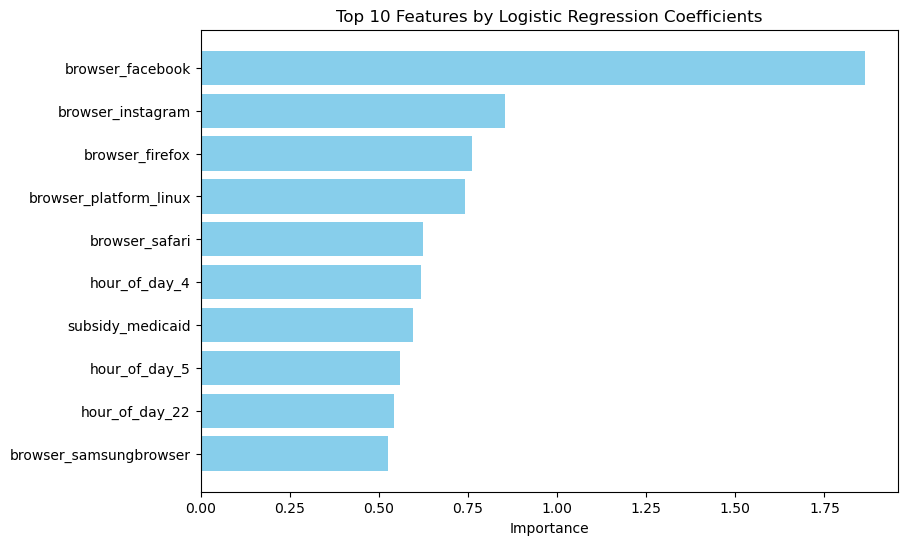

In [352]:
# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression Model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Model Evaluation
y_pred_lr = lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_lr)*100)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

coefficients = lr.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
top_10 = feature_importance.sort_values('Importance', ascending=False).head(10)

# Plot the top 10 features by importance
plt.figure(figsize=(9, 6))
plt.barh(top_10['Feature'], top_10['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Features by Logistic Regression Coefficients')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

The logistic regression model fit above has an accuracy of about 84% and according to the coefficients of the model, the top 10 most important features in conversion are browser, hour_of_day, subsidy, etc. 

#### Random Forest

ROC AUC Score: 0.614038866129036
Random Forest Accuracy: 82.20255653883972
Random Forest Confusion Matrix:
 [[3318  105]
 [ 619   26]]
Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.97      0.90      3423
         1.0       0.20      0.04      0.07       645

    accuracy                           0.82      4068
   macro avg       0.52      0.50      0.48      4068
weighted avg       0.74      0.82      0.77      4068



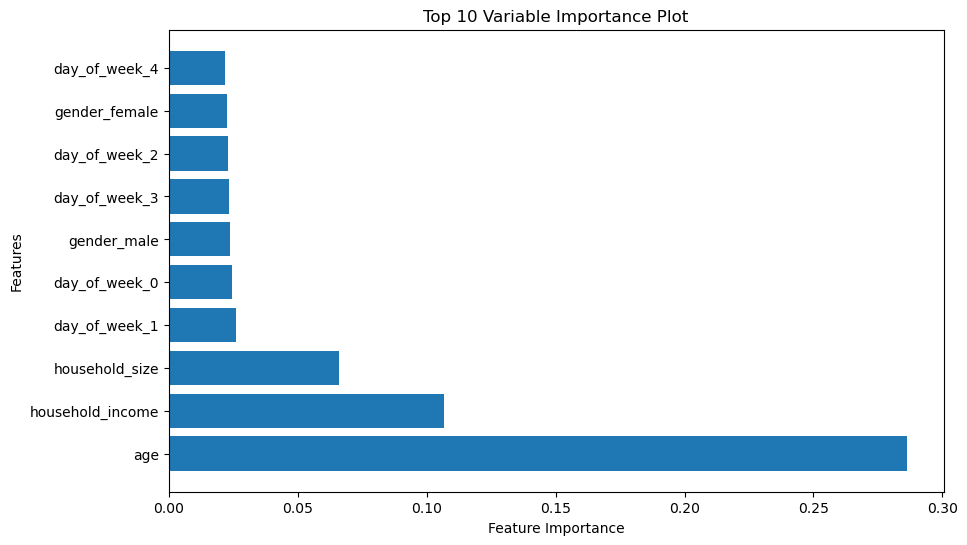

In [353]:
# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1] # Probability of positive class 

# Evaluate
auc_score = roc_auc_score(y_test, y_pred_proba_rf)
print(f'ROC AUC Score: {auc_score}')
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf)*100)
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

# Variable Importance Plot
feature_importance = rf.feature_importances_
sorted_idx = feature_importance.argsort()[::-1]
sorted_features = X.columns[sorted_idx]

# Plot only the top 7 features
top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:top_n], feature_importance[sorted_idx][:top_n])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'Top {top_n} Variable Importance Plot')
plt.show()

The random forest model, which is an ensemble tree-based model, resulted in a test accuracy of about 82.2% but the ROC-AUC Score being close to 0.61 means that our model can do much better and right now is close to random guessing with the given data.
The feature importance plot shows age, household income and household size as the most important features.

The feature importance differs in both methods since logistic regression is a statistical model while random forest is an ensemble learing tree-model. Logistic Regression calculates feature coefficients with all features as input, while Random Forest calculates importance values separately for each feature based on impurity reduction/gain during tree-building.

### Making Conversion Likelihood Predictions

In [354]:
# Preparing the unknown_outcomes dataset for prediction using Logistic Regression model
unknown_outcomes = merged[merged['conversion'] == -1]
unknown_outcomes.set_index('call_id', inplace=True)
# Drop unnecessary columns
unknown_outcomes.drop(columns=['phone_num_hash', 'buyer_id', 'time', 'source_id',
                               'time', 'call_duration', 'state', 'seller_type', 
                               'seller_id', 'conversion'], inplace=True)

# Convert columns to categorical
for col in convert_cols:
    unknown_outcomes[col] = unknown_outcomes[col].astype('category')

# Separate numerical and categorical columns
unknown_num_cols = unknown_outcomes.select_dtypes(include=['int64', 'float64']).columns
unknown_cat_cols = unknown_outcomes.select_dtypes(include=['object', 'category']).columns

# Normalize numerical columns using the same scaler
unknown_outcomes[unknown_num_cols] = scaler.transform(unknown_outcomes[unknown_num_cols])

# One-hot encode categorical columns using the same encoder
unknown_outcomes = pd.get_dummies(unknown_outcomes, columns=unknown_cat_cols)

# Predict probabilities of conversion
y_pred_proba = np.round(lr.predict_proba(unknown_outcomes)[:, 1], 3)  # Probability of class 1 (conversion)

# Add predicted probabilities to unknown_outcomes dataset
unknown_outcomes['predicted_conversion_probability'] = y_pred_proba

# Display or save predictions as needed
unknown_outcomes.head(10)

/var/folders/yw/42xscsr10q573yfmjt23989r0000gn/T/ipykernel_81129/3962025085.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_outcomes.drop(columns=['phone_num_hash', 'buyer_id', 'time', 'source_id',
/var/folders/yw/42xscsr10q573yfmjt23989r0000gn/T/ipykernel_81129/3962025085.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_outcomes[col] = unknown_outcomes[col].astype('category')
/var/folders/yw/42xscsr10q573yfmjt23989r0000gn/T/ipykernel_81129/3962025085.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

,age,household_income,household_size,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,...,device_computer,device_mobile,device_tablet,gender_female,gender_male,gender_nonbinary,subsidy_medicaid,subsidy_no,subsidy_yes,predicted_conversion_probability
call_id,,,,,,,,,,,,,,,,,,,,,
CA25123ac8ae1550d20702684e9b383a9d,0.742480,-0.008905,-0.620384,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,1,0.126
CA0bf360c2e450496ab7f9827ca53c2782,-0.017891,-0.008457,-0.620384,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,1,0.128
CA2c303f8186fcf2783398916949fbdfbc,1.122666,-0.008457,0.238161,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,1,0.123
CA694b6e2c7ed47d0ccb070e63339b3703,0.853080,-0.006831,1.955252,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,1,0.264
CAe560088516553c703a6e2426a3295994,-0.232177,-0.009284,-0.620384,1,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0.074
CAc23135030f5fe810b6c508bc657679db,-1.275960,-0.006831,-0.620384,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0.140
CA6e599b9cd276e5e5c0b198ab146e779f,-0.425726,-0.008457,1.096707,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0.234
CA27cd34d16a49194005546b05a6b095c6,1.060454,-0.008986,-0.620384,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0.220
CAcf6ae44faec6f751f0f9716bf1d8e86d,1.419902,-0.009542,-0.620384,1,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0.113


As a side note, I had initially included the feature `seller_id` in my training data but upon trying to make predictions, some of the seller id's not present in the training data came up in the unknown outcomes data, which prevents me from making predictions. Hence, I had to remove that feature. 

#### Adding the predictions of likelihood to the originial merged dataset.

In [355]:
# making call_id a column again
unknown_outcomes.reset_index(inplace=True)

# Merge predicted probabilities back to merged dataframe based on call_id
merged = merged.merge(unknown_outcomes[['call_id', 'predicted_conversion_probability']], on='call_id', how='left')

# Final Dataframe with predicted probabilities for conversion
merged.head()

,call_id,phone_num_hash,buyer_id,source_id,time,call_duration,conversion,day_of_week,hour_of_day,state,...,browser_platform,device,age,gender,household_income,household_size,subsidy,seller_id,seller_type,predicted_conversion_probability
0,CA25123ac8ae1550d20702684e9b383a9d,1E203B4634DCA46E4D4045C9CCAB0C14177B510A19AB14...,34844.0,3330,2023-10-01 00:18:54,145,-1.0,6,0,PA,...,android,mobile,51.3,male,23500.0,1,yes,507,owned_and_operated,0.126
1,CA0bf360c2e450496ab7f9827ca53c2782,C0A651D4E963BF925E4B641C456C219944346F7D0C2C1B...,66836.0,3330,2023-10-01 12:19:35,1705,-1.0,6,12,KY,...,android,mobile,40.3,male,40000.0,1,yes,507,owned_and_operated,0.128
2,CA2c303f8186fcf2783398916949fbdfbc,6FF94E1E927AB3269BA8ACB0DC13FDB4CD5E5D6C26563C...,1987.0,3330,2023-10-01 18:41:09,1,-1.0,6,18,LA,...,android,mobile,56.8,male,40000.0,2,yes,507,owned_and_operated,0.123
3,CA694b6e2c7ed47d0ccb070e63339b3703,B3B0CE54CBB8C872CFEFF86EC3767A383200537A5C0094...,2486.0,3330,2023-10-01 22:34:43,156,-1.0,6,22,AZ,...,ios,mobile,52.9,male,100000.0,4,yes,507,owned_and_operated,0.264
4,CAe560088516553c703a6e2426a3295994,EB098A09FA9EF17E3D34B97168EBF924BF253A81DD32A2...,1728.0,3330,2023-10-02 06:04:34,159,-1.0,0,6,GA,...,android,mobile,37.2,female,9500.0,1,medicaid,507,owned_and_operated,0.074


Distribution of the predicted probablities

<Axes: xlabel='predicted_conversion_probability', ylabel='Count'>

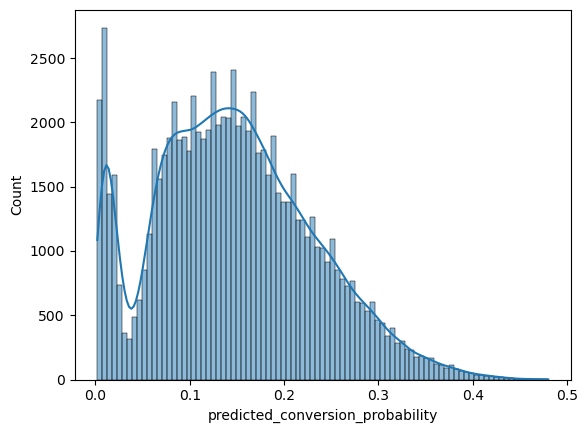

In [356]:
sns.histplot(merged['predicted_conversion_probability'], kde=True)

To summarize my findings, the likelihood of conversion for every call in the dataset is included in the dataset `merged` above in the `predicted_conversion_probability` column and can be identified by the unique `call_id`.

Logistic Regression helped find a relationship between the conversion outcome, which is a binary variable (success or failure of the call in getting business), and the other variables in the dataset. The feature importance numbers/visualization told us about the features that were the most influential in driving the conversions using the model coefficients which tell us how much each variable affects the outcome variable.

### Looking at the type of calls to convert (Boxplots and Scatterplots)

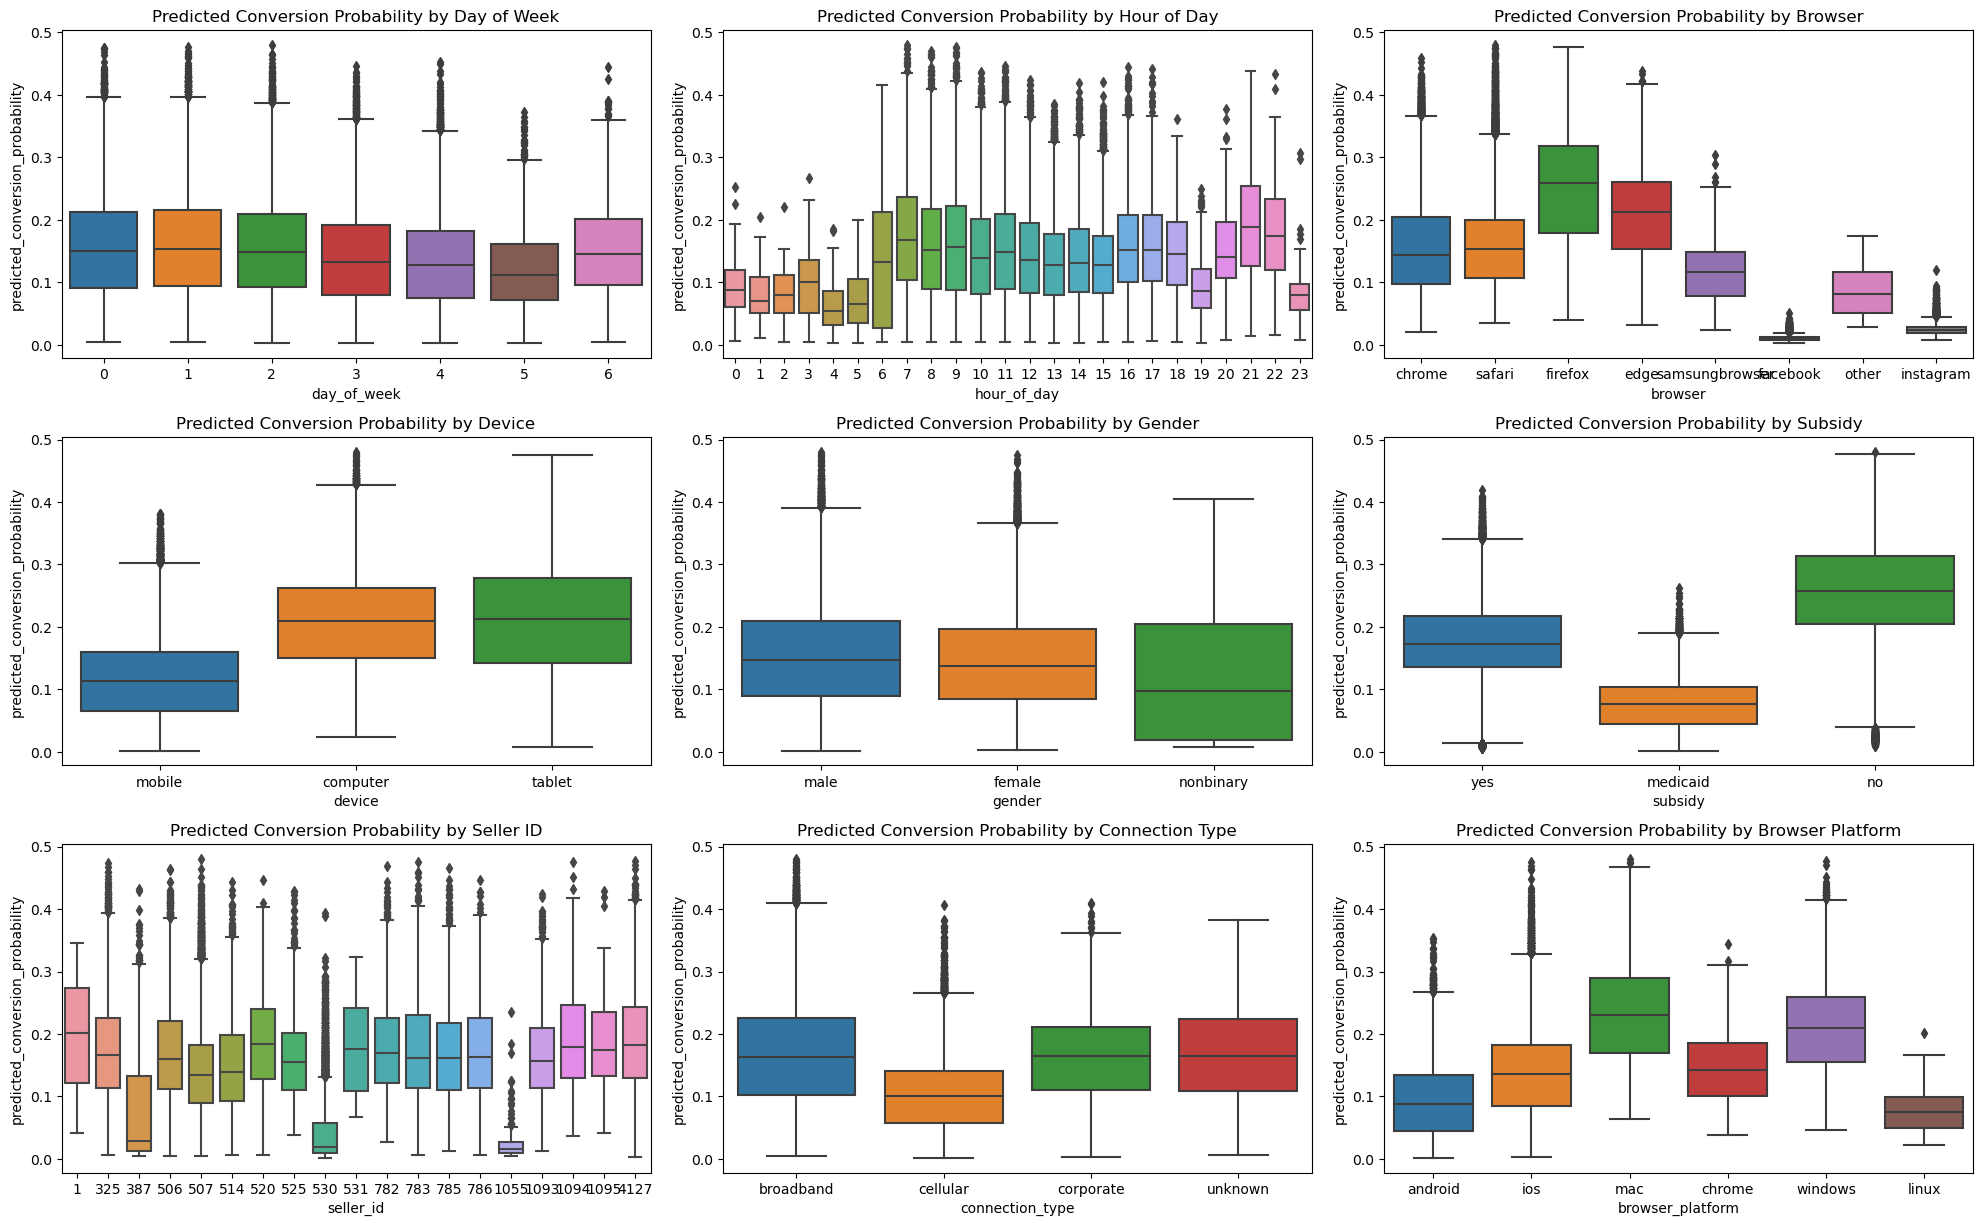

In [357]:
all_probs = merged[merged['conversion'] == -1]

plt.figure(figsize=(20, 16))

# Predicted probability by day of the week
plt.subplot(4, 3, 1)
sns.boxplot(data=all_probs, x='day_of_week', y='predicted_conversion_probability')
plt.title('Predicted Conversion Probability by Day of Week')

# Predicted probability by hour of day
plt.subplot(4, 3, 2)
sns.boxplot(data=all_probs, x='hour_of_day', y='predicted_conversion_probability')
plt.title('Predicted Conversion Probability by Hour of Day')

# Predicted probability by browser
plt.subplot(4, 3, 3)
sns.boxplot(data=all_probs, x='browser', y='predicted_conversion_probability')
plt.title('Predicted Conversion Probability by Browser')

# Predicted probability by device
plt.subplot(4, 3, 4)
sns.boxplot(data=all_probs, x='device', y='predicted_conversion_probability')
plt.title('Predicted Conversion Probability by Device')

# Predicted probability by gender
plt.subplot(4, 3, 5)
sns.boxplot(data=all_probs, x='gender', y='predicted_conversion_probability')
plt.title('Predicted Conversion Probability by Gender')

# Predicted probability by subsidy
plt.subplot(4, 3, 6)
sns.boxplot(data=all_probs, x='subsidy', y='predicted_conversion_probability')
plt.title('Predicted Conversion Probability by Subsidy')

# Predicted probability by seller_id
plt.subplot(4, 3, 7)
sns.boxplot(data=all_probs, x='seller_id', y='predicted_conversion_probability')
plt.title('Predicted Conversion Probability by Seller ID')

# Predicted probability by connection_type
plt.subplot(4, 3, 8)
sns.boxplot(data=all_probs, x='connection_type', y='predicted_conversion_probability')
plt.title('Predicted Conversion Probability by Connection Type')

# Predicted probability by browser_platform
plt.subplot(4, 3, 9)
sns.boxplot(data=all_probs, x='browser_platform', y='predicted_conversion_probability')
plt.title('Predicted Conversion Probability by Browser Platform')

plt.tight_layout()
plt.show()

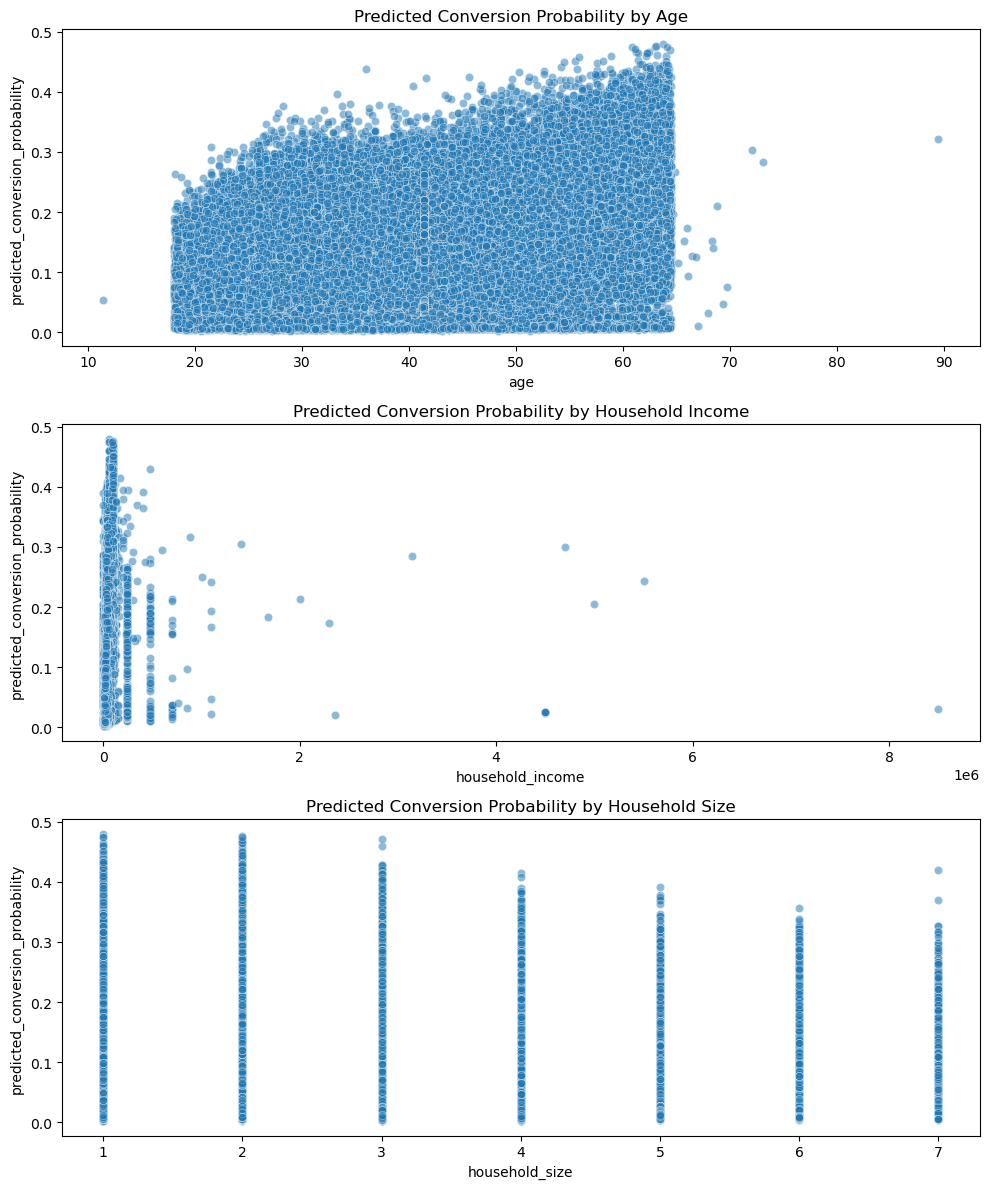

In [358]:
plt.figure(figsize=(10, 12))

# Predicted probability by age
plt.subplot(3, 1, 1)
sns.scatterplot(data=all_probs, x='age', y='predicted_conversion_probability', alpha=0.5)
plt.title('Predicted Conversion Probability by Age')

# Predicted probability by household_income
plt.subplot(3, 1, 2)
sns.scatterplot(data=all_probs, x='household_income', y='predicted_conversion_probability', alpha=0.5)
plt.title('Predicted Conversion Probability by Household Income')

# Predicted probability by household_size
plt.subplot(3, 1, 3)
sns.scatterplot(data=all_probs, x='household_size', y='predicted_conversion_probability', alpha=0.5)
plt.title('Predicted Conversion Probability by Household Size')

plt.tight_layout()
plt.show()

Looking at the distribution of the predicted probabilities across the features, the type of calls to most likely convert are:
- more so made on Mondays, Tuesdays, and Wednesdays
- made between 7am - 9am or around 9pm
- on firefox or edge browsers
- on computer device or tablet
- caller is without subsidy eligibility status
- caller has a broadband connection 
- on a Mac/Windows browser platform
- caller between the age of 45-65
- caller with household income below 50,000
- caller with household size less than 3

These findings are made based on a model trained on a small dataset (about 13k rows or datapoints) so the accuracy may not be great. However, in future work, training a model with more data could make the predictions better. The reason why the predicted likelihoods are so low may be due to the fact that majority of the training data (conversion data for buyer 63253) had negative conversion values than positive. A more balanced dataset either by data collection or data augmentation (creation of new data from previously collected data) could make the model better.